# Neural Network Predictive Maintenance System

Predictive maintenance of elevators doors in order to reduce unplanned stops and maximizing equipment life cycle.

*"If component A is showing over 20% baseline vibrations, while the temperature rises 0.5 degrees in component B, and the noise level rises with 10.6dB then it is likely that the doors will break in about 5 to 7 days.”*

Monitoring of elevator performance across 10+ parameters, such as:
- time it takes for doors to open and close
- ball bearing sensor
- vibration and noise level
- abnormal stops
- humidity, air pressure, and temperature etc.

Learn normal operative parameters and sensory correlations in order to:
- Define bounds for min/max ranges of critical parameters
- Generate alarms for anomaly situations (i.e. door not closing properly)

In [ ]:
# useful packages
import numpy as np
import matplotlib.pyplot as plt
from obs import *
import csv
import io
import time

For an elevator car door the system can learn the correlation between: 
- Electromechanical sensors (Door Ball Bearing Sensor) 
- Ambiance(Humidity) 
- Physics(Vibration)

Once learnt the correlation in operational settings we can use it to infer  anomalous operation of the doors.

In [6]:
# load first dataset
sensoryPairName1 = 'sensory_data_humidity_vibration.csv';

# load the second dataset 
sensoryPairName2 = 'sensory_data_ball_bearing_vibration.csv';

# load the third dataset 
sensoryPairName3 = 'sensory_data_ball_bearing_humidity.csv';

In [7]:
# compute the value of the logistic function for single neuron dynamics
# given the slope, m, and the shift, s
def compute_s(x, m ,s):
    y = np.zeros((len(x), 1))
    for idx in range(len(x)):
        y[idx, 0] = 1/(1 + np.exp(-m*(x[idx, 0] - s)))
    return y

In [8]:
# compute topological distance between activations in each of the neurons
def compute_d(N, s):
    y = np.zeros((N, N))
    for idx in range(N):
        for jdx in range(N):
            y[idx, jdx] = np.exp(-0.5*(np.min([np.abs(idx-jdx), N - np.abs(idx-jdx)])/s) ** 2)
    return y

In [9]:
# create the learning network composed of N_POP populations of
# N_NEURONS neurons and init each struct weight and activity matrices
def create_init_network(N_POP, N_NEURONS, GAMMA, SIGMA, DELTA, MAX_INIT_RANGE, TARGET_VAL_ACT):
    wta_profile = GAMMA * compute_d(N_NEURONS, SIGMA) - DELTA;
    wext = np.random.rand(N_NEURONS, N_NEURONS)*MAX_INIT_RANGE;
    populations = {}
    for pop_idx in range(N_POP):
        populations[pop_idx] = {'idx': pop_idx,
                                'lsize': N_NEURONS,
                                'Wint': wta_profile,
                                'Wext': wext / np.sum(wext),
                                'a': np.zeros((N_NEURONS, 1))*TARGET_VAL_ACT,
                                'h': np.zeros((N_NEURONS, 1))*TARGET_VAL_ACT
                               }
    return populations

In [10]:
# function to generate the population encoded variable as input for the net
# here we also need to encode variables which are in both +/- ranges
# we need to take into accound the encoding for the tuning curves
# distribution
def population_encoder(x, range_input, N):
    sig = .1  # Standard deviation
    K = 1; # max firing rate (Hz) (ignore - not modeling nurophysiology here :)
    # pattern of activity, or output tuning curve between [-range, range]
    R = np.zeros((N, 1))
    # calculate output 
    for j in range(N):  # for each neuron in the population
        R[j, 0] = K*np.exp( -(x - (-range_input+(j)*(range_input/((N)/2))))**2 / (2*sig**2))
    return R

In [11]:
# plot a heatmap 
def print_heatmap(arr):
    plt.figure()
    plt.imshow(arr)
    plt.show()

In [2]:
## INIT SIMULATION
# enables dynamic visualization on network runtime
DYN_VISUAL      = 1
# number of populations in the network
N_POP           = 2
# number of neurons in each population
N_NEURONS       = 200
# max range value @ init for weights and activities in the population
MAX_INIT_RANGE  = 1
# WTA circuit settling threshold
EPSILON         = 1e-3
## INIT NETWORK DYNAMICS
# epoch iterator in outer loop (HL, HAR)
t       = 1;
# network iterator in inner loop (WTA)
tau     = 1;
# constants for WTA circuit (convolution based WTA), these will provide a
# profile peaked at ~ TARGET_VAL_ACT
DELTA   = -0.005                   # displacement of the convolutional kernel (neighborhood)
SIGMA   = 5.0                      # standard deviation in the exponential update rule
SL      = 4.5                      # scaling factor of neighborhood kernel
GAMMA   = SL/(SIGMA*np.sqrt(2*np.pi))    # convolution scaling factor
# constants for Hebbian linkage
ALPHA_L = 1.0*1e-2                 # Hebbian learning rate
ALPHA_D = 1.0*1e-2                 # Hebbian decay factor ALPHA_D >> ALPHA_L
# constants for HAR
C       = 0.005                    # scaling factor in homeostatic activity regulation
TARGET_VAL_ACT  = 0.4              # amplitude target for HAR
A_TARGET        = TARGET_VAL_ACT*np.ones((N_NEURONS, 1)) # HAR target activity vector
# constants for neural units in neural populations
M       = 1; # slope in logistic function @ neuron level
S       = 10.0; # shift in logistic function @ neuron level
# activity change weight (history vs. incoming knowledge)
ETA     = 0.25;

## SENSORY DATA SETUP 

# prepare first dataset
# bind sensory data
sensory_data1 = trainData1;
# normalize data
sensory_data_range = 1.0;
minVals1 = min(sensory_data1[:, 0]);
maxVals1 = max(sensory_data1[:, 0]);
sensory_data1[:, 0] = (((sensory_data1[:, 0] - minVals1) * (sensory_data_range - (-sensory_data_range))) / (maxVals1 - minVals1)) + (-sensory_data_range);
minVals2 = min(sensory_data1[:, 1]);
maxVals2 = max(sensory_data1[:, 1]);
sensory_data1[:, 1] = (((sensory_data1[:, 1] - minVals2) * (sensory_data_range - (-sensory_data_range))) / (maxVals2 - minVals2)) + (-sensory_data_range);
# get data len
DATASET_LEN     = len(sensory_data1[:, 0])

# prepare second dataset
# bind sensory data
sensory_data2 = trainData2;
# normalize data
minVals1 = min(sensory_data2[:, 0]);
maxVals1 = max(sensory_data2[:, 0]);
sensory_data2[:, 0] = (((sensory_data2[:, 0] - minVals1) * (sensory_data_range - (-sensory_data_range))) / (maxVals1 - minVals1)) + (-sensory_data_range);
minVals2 = min(sensory_data2[:, 1]);
maxVals2 = max(sensory_data2[:, 1]);
sensory_data2[:, 1] = (((sensory_data2[:, 1] - minVals2) * (sensory_data_range - (-sensory_data_range))) / (maxVals2 - minVals2)) + (-sensory_data_range);

# prepare third dataset
# bind sensory data
sensory_data3 = trainData3;
# normalize data
minVals1 = min(sensory_data3[:, 0]);
maxVals1 = max(sensory_data3[:, 0]);
sensory_data3[:, 0] = (((sensory_data3[:, 0] - minVals1) * (sensory_data_range - (-sensory_data_range))) / (maxVals1 - minVals1)) + (-sensory_data_range);
minVals2 = min(sensory_data3[:, 1]);
maxVals2 = max(sensory_data3[:, 1]);
sensory_data3[:, 1] = (((sensory_data3[:, 1] - minVals2) * (sensory_data_range - (-sensory_data_range))) / (maxVals2 - minVals2)) + (-sensory_data_range);

## CREATE NETWORK AND INITIALIZE

# create network for the first dataset
# create a network given the simulation constants
populations1 = create_init_network(N_POP, N_NEURONS, GAMMA, SIGMA, DELTA, MAX_INIT_RANGE, TARGET_VAL_ACT)
# buffers for changes in activity in WTA loop
act1 = np.zeros((N_NEURONS, N_POP))*MAX_INIT_RANGE
old_act1 = np.zeros((N_NEURONS, N_POP))*MAX_INIT_RANGE
# buffers for running average of population activities in HAR loop
old_avg1 = np.zeros((N_POP, N_NEURONS))
cur_avg1 = np.zeros((N_POP, N_NEURONS))
# the new rate values
delta_a0_1 = np.zeros((N_NEURONS, 1))
delta_a1_1 = np.zeros((N_NEURONS, 1))
tau1 = tau

# create network for the second dataset
# create a network given the simulation constants
populations2 = create_init_network(N_POP, N_NEURONS, GAMMA, SIGMA, DELTA, MAX_INIT_RANGE, TARGET_VAL_ACT)
# buffers for changes in activity in WTA loop
act2 = np.zeros((N_NEURONS, N_POP))*MAX_INIT_RANGE
old_act2 = np.zeros((N_NEURONS, N_POP))*MAX_INIT_RANGE
# buffers for running average of population activities in HAR loop
old_avg2 = np.zeros((N_POP, N_NEURONS))
cur_avg2 = np.zeros((N_POP, N_NEURONS))
# the new rate values
delta_a0_2 = np.zeros((N_NEURONS, 1))
delta_a1_2 = np.zeros((N_NEURONS, 1))
tau2 = tau

# create network for the third dataset
# create a network given the simulation constants
populations3 = create_init_network(N_POP, N_NEURONS, GAMMA, SIGMA, DELTA, MAX_INIT_RANGE, TARGET_VAL_ACT)
# buffers for changes in activity in WTA loop
act3 = np.zeros((N_NEURONS, N_POP))*MAX_INIT_RANGE
old_act3 = np.zeros((N_NEURONS, N_POP))*MAX_INIT_RANGE
# buffers for running average of population activities in HAR loop
old_avg3 = np.zeros((N_POP, N_NEURONS))
cur_avg3 = np.zeros((N_POP, N_NEURONS))
# the new rate values
delta_a0_3 = np.zeros((N_NEURONS, 1))
delta_a1_3 = np.zeros((N_NEURONS, 1))
tau3 = tau

## NETWORK SIMULATION LOOP
# # present each entry in the dataset for MAX_EPOCHS epochs to train the net
for didx in range(DATASET_LEN):
      
    didx = didx + 1
    # loop for the first dataset
    # pick a new sample from the dataset and feed it to the input (noiseless input)
    # population in the network (in this case X -> A -> | <- B <- Y)
    X1 = population_encoder(sensory_data1[didx, 0], np.max(sensory_data1[:, 0]),  N_NEURONS)
    Y1 = population_encoder(sensory_data1[didx, 1], np.max(sensory_data1[:, 1]),  N_NEURONS)
    # normalize input such that the activity in all units sums to 1.0
    X1 /= np.sum(X1)
    Y1 /= np.sum(Y1)
    # clamp input to neural populations
    populations1[0]['a'] = X1
    populations1[1]['a'] = Y1
    # given the input sample wait for WTA circuit to settle and then
    # perform a learning step of Hebbian learning and HAR
    while True:
        # compute changes in activity
        delta_a0_1 = compute_s(populations1[0]['h'] + np.matmul(populations1[0]['Wext'], populations1[1]['a']) + 
                             np.matmul(populations1[0]['Wint'],populations1[0]['a']), 
                             M, 
                             S)
        delta_a1_1 = compute_s(populations1[1]['h'] + np.matmul(populations1[1]['Wext'], populations1[0]['a']) + 
                             np.matmul(populations1[1]['Wint'], populations1[1]['a']), 
                             M, 
                             S)
        # update the activities of each population
        populations1[0]['a'] = (1-ETA)*populations1[0]['a'] + ETA*delta_a0_1
        populations1[1]['a'] = (1-ETA)*populations1[1]['a'] + ETA*delta_a1_1
        # current activation values holder
        for pop_idx in range(N_POP):
            act1[:, pop_idx] = populations1[pop_idx]['a'].reshape(-1)
        # check if activity has settled in the WTA loop
        q1 = (np.sum(np.sum(np.abs(act1 - old_act1)))/(N_POP*N_NEURONS))
        if q1 <= EPSILON:
            tau1 = 1
            break
        # update history of activities
        old_act1 = act1
        # increment time step in WTA loop
        tau1 += 1
    # update Hebbian linkage between the populations (decaying Hebbian rule)
    populations1[0]['Wext'] = (1-ALPHA_D)*populations1[0]['Wext'] + ALPHA_L*np.matmul(populations1[0]['a'],populations1[1]['a'].transpose())
    populations1[1]['Wext'] = (1-ALPHA_D)*populations1[1]['Wext'] + ALPHA_L*np.matmul(populations1[1]['a'],populations1[0]['a'].transpose())
    # compute the inverse time for exponential averaging of HAR activity
    omegat1 = 0.002 + 0.998/(t+2)
    # for each population in the network
    for pop_idx in range(N_POP):
        # update Homeostatic Activity Regulation terms
        # compute exponential average of each population at current step
        cur_avg1[pop_idx, :] = (1-omegat1)*old_avg1[pop_idx, :] + omegat1*populations1[pop_idx]['a'].transpose()
        # update homeostatic activity terms given current and target act.
        populations1[pop_idx]['h'] = populations1[pop_idx]['h'] + C*(TARGET_VAL_ACT - cur_avg1[pop_idx, :].transpose())
    # update averging history
    old_avg1 = cur_avg1
    
    # loop for the second dataset
    # pick a new sample from the dataset and feed it to the input (noiseless input)
    # population in the network (in this case X -> A -> | <- B <- Y)
    X2 = population_encoder(sensory_data2[didx, 0], np.max(sensory_data2[:, 0]),  N_NEURONS)
    Y2 = population_encoder(sensory_data2[didx, 1], np.max(sensory_data2[:, 1]),  N_NEURONS)
    # normalize input such that the activity in all units sums to 1.0
    X2 /= np.sum(X2)
    Y2 /= np.sum(Y2)
    # clamp input to neural populations
    populations2[0]['a'] = X2
    populations2[1]['a'] = Y2
    # given the input sample wait for WTA circuit to settle and then
    # perform a learning step of Hebbian learning and HAR
    while True:
        # compute changes in activity
        delta_a0_2 = compute_s(populations2[0]['h'] + np.matmul(populations2[0]['Wext'], populations2[1]['a']) + 
                             np.matmul(populations2[0]['Wint'],populations2[0]['a']), 
                             M, 
                             S)
        delta_a1_2 = compute_s(populations2[1]['h'] + np.matmul(populations2[1]['Wext'], populations2[0]['a']) + 
                             np.matmul(populations2[1]['Wint'], populations2[1]['a']), 
                             M, 
                             S)
        # update the activities of each population
        populations2[0]['a'] = (1-ETA)*populations2[0]['a'] + ETA*delta_a0_2
        populations2[1]['a'] = (1-ETA)*populations2[1]['a'] + ETA*delta_a1_2
        # current activation values holder
        for pop_idx in range(N_POP):
            act2[:, pop_idx] = populations2[pop_idx]['a'].reshape(-1)
        # check if activity has settled in the WTA loop
        q2 = (np.sum(np.sum(np.abs(act2 - old_act2)))/(N_POP*N_NEURONS))
        if q2 <= EPSILON:
            tau2 = 1
            break
        # update history of activities
        old_act2 = act2
        # increment time step in WTA loop
        tau2 += 1
    # update Hebbian linkage between the populations (decaying Hebbian rule)
    populations2[0]['Wext'] = (1-ALPHA_D)*populations2[0]['Wext'] + ALPHA_L*np.matmul(populations2[0]['a'],populations2[1]['a'].transpose())
    populations2[1]['Wext'] = (1-ALPHA_D)*populations2[1]['Wext'] + ALPHA_L*np.matmul(populations2[1]['a'],populations2[0]['a'].transpose())
    # compute the inverse time for exponential averaging of HAR activity
    omegat2 = 0.002 + 0.998/(t+2)
    # for each population in the network
    for pop_idx in range(N_POP):
        # update Homeostatic Activity Regulation terms
        # compute exponential average of each population at current step
        cur_avg2[pop_idx, :] = (1-omegat2)*old_avg2[pop_idx, :] + omegat2*populations2[pop_idx]['a'].transpose()
        # update homeostatic activity terms given current and target act.
        populations2[pop_idx]['h'] = populations2[pop_idx]['h'] + C*(TARGET_VAL_ACT - cur_avg2[pop_idx, :].transpose())
    # update averging history
    old_avg2 = cur_avg2
    
    # loop for the third dataset
    # pick a new sample from the dataset and feed it to the input (noiseless input)
    # population in the network (in this case X -> A -> | <- B <- Y)
    X3 = population_encoder(sensory_data3[didx, 0], np.max(sensory_data3[:, 0]),  N_NEURONS)
    Y3 = population_encoder(sensory_data3[didx, 1], np.max(sensory_data3[:, 1]),  N_NEURONS)
    # normalize input such that the activity in all units sums to 1.0
    X3 /= np.sum(X3)
    Y3 /= np.sum(Y3)
    # clamp input to neural populations
    populations3[0]['a'] = X3
    populations3[1]['a'] = Y3
    # given the input sample wait for WTA circuit to settle and then
    # perform a learning step of Hebbian learning and HAR
    while True:
        # compute changes in activity
        delta_a0_3 = compute_s(populations3[0]['h'] + np.matmul(populations3[0]['Wext'], populations3[1]['a']) + 
                             np.matmul(populations3[0]['Wint'],populations3[0]['a']), 
                             M, 
                             S)
        delta_a1_3 = compute_s(populations3[1]['h'] + np.matmul(populations3[1]['Wext'], populations3[0]['a']) + 
                             np.matmul(populations3[1]['Wint'], populations3[1]['a']), 
                             M, 
                             S)
        # update the activities of each population
        populations3[0]['a'] = (1-ETA)*populations3[0]['a'] + ETA*delta_a0_3
        populations3[1]['a'] = (1-ETA)*populations3[1]['a'] + ETA*delta_a1_3
        # current activation values holder
        for pop_idx in range(N_POP):
            act3[:, pop_idx] = populations3[pop_idx]['a'].reshape(-1)
        # check if activity has settled in the WTA loop
        q3 = (np.sum(np.sum(np.abs(act3 - old_act3)))/(N_POP*N_NEURONS))
        if q3 <= EPSILON:
            tau3 = 1
            break
        # update history of activities
        old_act3 = act3
        # increment time step in WTA loop
        tau3 += 1
    # update Hebbian linkage between the populations (decaying Hebbian rule)
    populations3[0]['Wext'] = (1-ALPHA_D)*populations3[0]['Wext'] + ALPHA_L*np.matmul(populations3[0]['a'],populations3[1]['a'].transpose())
    populations3[1]['Wext'] = (1-ALPHA_D)*populations3[1]['Wext'] + ALPHA_L*np.matmul(populations3[1]['a'],populations3[0]['a'].transpose())
    # compute the inverse time for exponential averaging of HAR activity
    omegat3 = 0.002 + 0.998/(t+2)
    # for each population in the network
    for pop_idx in range(N_POP):
        # update Homeostatic Activity Regulation terms
        # compute exponential average of each population at current step
        cur_avg3[pop_idx, :] = (1-omegat3)*old_avg3[pop_idx, :] + omegat3*populations3[pop_idx]['a'].transpose()
        # update homeostatic activity terms given current and target act.
        populations3[pop_idx]['h'] = populations3[pop_idx]['h'] + C*(TARGET_VAL_ACT - cur_avg3[pop_idx, :].transpose())
    # update averging history
    old_avg3 = cur_avg3
    
    # increment timestep for HL and HAR loop
    t = t + 1
    
    # give time to write to update visualization
    time.sleep(2)
    # write inputs
    write_in(didx, np.matrix(sensory_data1[0:didx, :]), sensoryPairName1)
    write_in(didx, np.matrix(sensory_data2[0:didx, :]), sensoryPairName2)
    write_in(didx, np.matrix(sensory_data3[0:didx, :]), sensoryPairName3)
    # write results
    write_out(populations1[1]['Wext'], sensoryPairName1)
    write_out(populations2[1]['Wext'], sensoryPairName2)
    write_out(populations3[1]['Wext'], sensoryPairName3)

NameError: name 'trainData1' is not defined

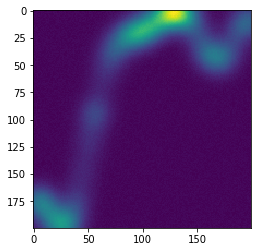

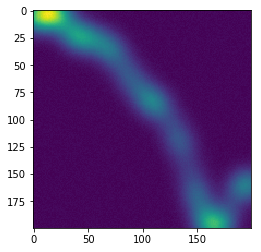

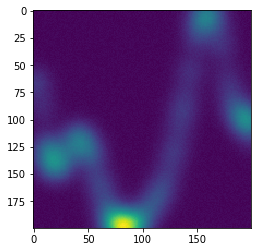

In [47]:
# print to verify
print_heatmap(populations1[1]['Wext']); print_heatmap(populations2[1]['Wext']) ; print_heatmap(populations3[1]['Wext']);